In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import japanize_matplotlib
import shap
pd.set_option("display.max_columns",None)

In [22]:
results = pd.read_csv("../results/predictions/decision_tree_predictions.csv")
X_test = pd.read_csv("../results/predictions/decision_tree_X_test.csv")
display(results.head())
display(X_test.head())

,Actual,Predicted
0,0.975434,0.997113
1,0.965628,0.890215
2,0.969909,1.000000
3,0.999104,0.800960
4,0.966051,0.884713


,Average_Temperature (℃),Total_Precipitation (mm),Average_wind_speed(m/s),Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Opponent_DeNA,Opponent_オリックス,Opponent_ヤクルト,Opponent_ロッテ,Opponent_中日,Opponent_巨人,Opponent_広島,Opponent_日本ハム,Opponent_楽天,Opponent_西武,Opponent_阪神,Is_Holiday,Match_Number,Rain_Zero_Flag
0,18.1,9.5,2.2,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,17.3,62.0,3.2,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,2,0
2,14.8,1.5,4.4,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3,0
3,18.5,0.0,2.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,1
4,18.2,7.5,2.8,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,0


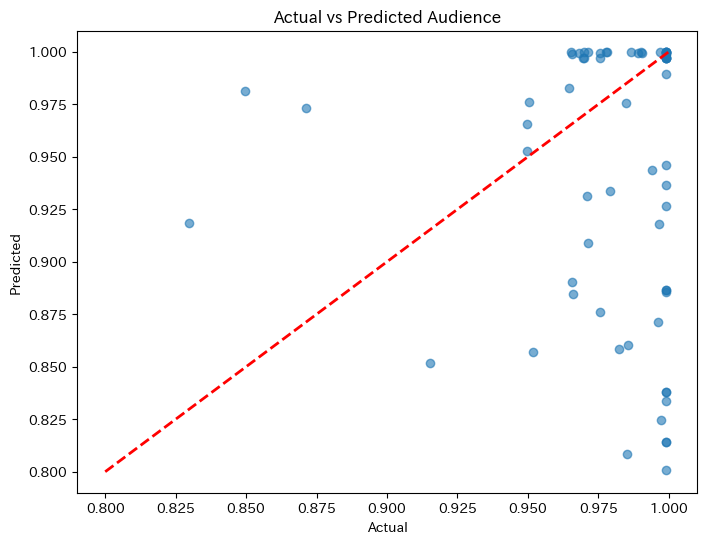

In [26]:
# 実際の観客数 vs 予測観客数
plt.figure(figsize=(8, 6))
plt.scatter(results.loc[:,"Actual"], results.loc[:,"Predicted"], alpha=0.6)
plt.plot([0.8, 1], [0.8, 1], 'r--', lw=2)  # 完璧な予測を示す直線
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Audience')
plt.savefig("../results/plots/Actual_VS_Predicted.png")
plt.show()

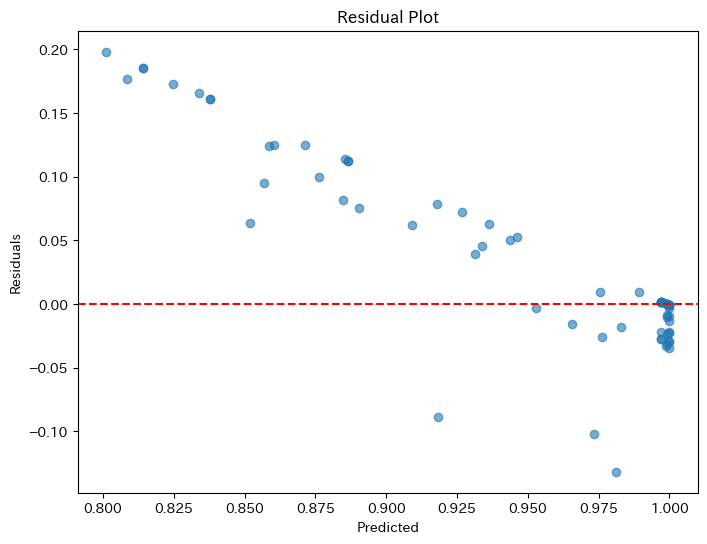

In [27]:
# 残差プロット (Residual Plot)
residuals = results.loc[:,"Actual"] - results.loc[:,"Predicted"]

plt.figure(figsize=(8, 6))
plt.scatter(results.loc[:,"Predicted"], residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.savefig("../results/plots/Residual_Plot.png")
plt.show()

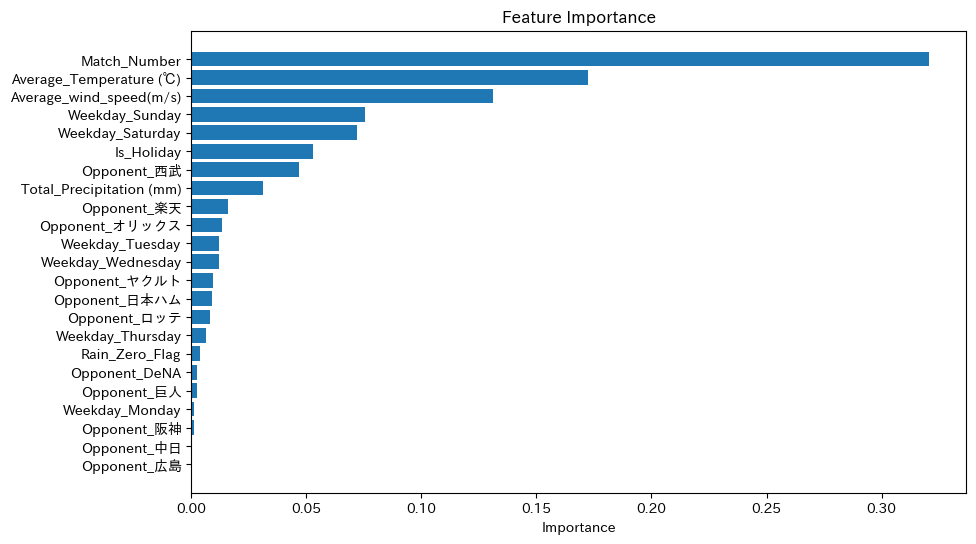

In [28]:
# 特徴量重要度の可視化
# モデルをロード
model = joblib.load('../results/models/decision_tree_model.pkl')
feature_importance = model.feature_importances_

# 特徴量の名前と重要度を対応させてDataFrameにする
feature_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=True)

# 可視化
plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'], feature_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')

plt.savefig("../results/plots/Feature_Importance.png")
plt.show()


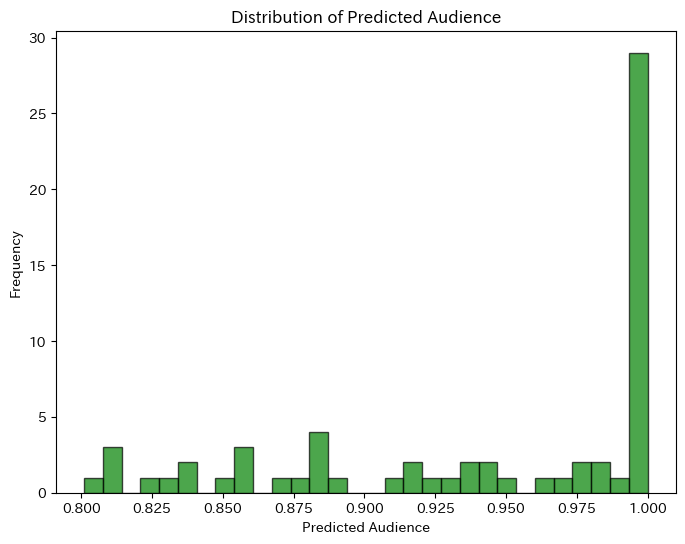

In [29]:
# 予測分布の可視化
plt.figure(figsize=(8, 6))
plt.hist(results.loc[:,"Predicted"], bins=30, alpha=0.7, color='g', edgecolor='black')
plt.xlabel('Predicted Audience')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Audience')
plt.savefig("../results/plots/Distribution.png")
plt.show()

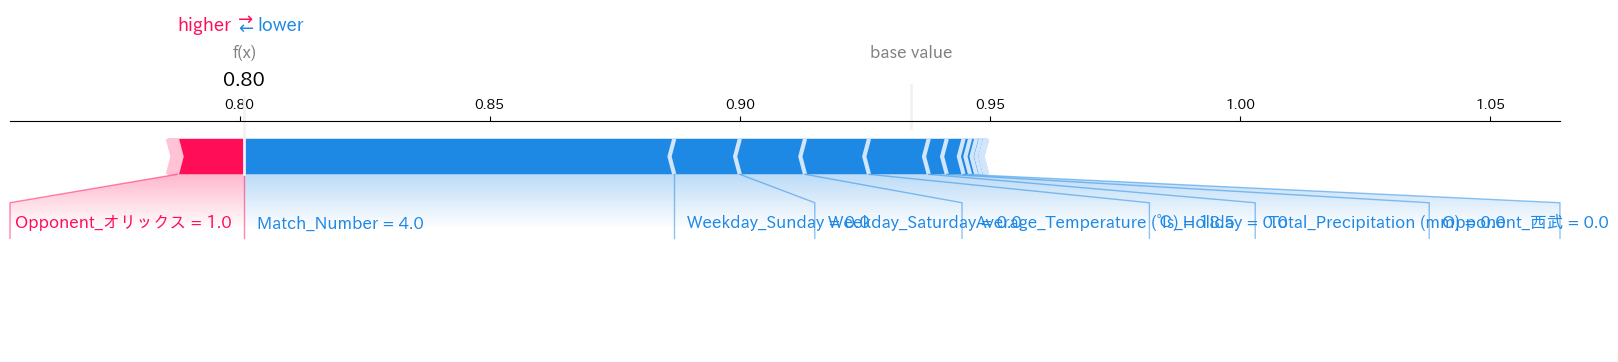

<Figure size 640x480 with 0 Axes>

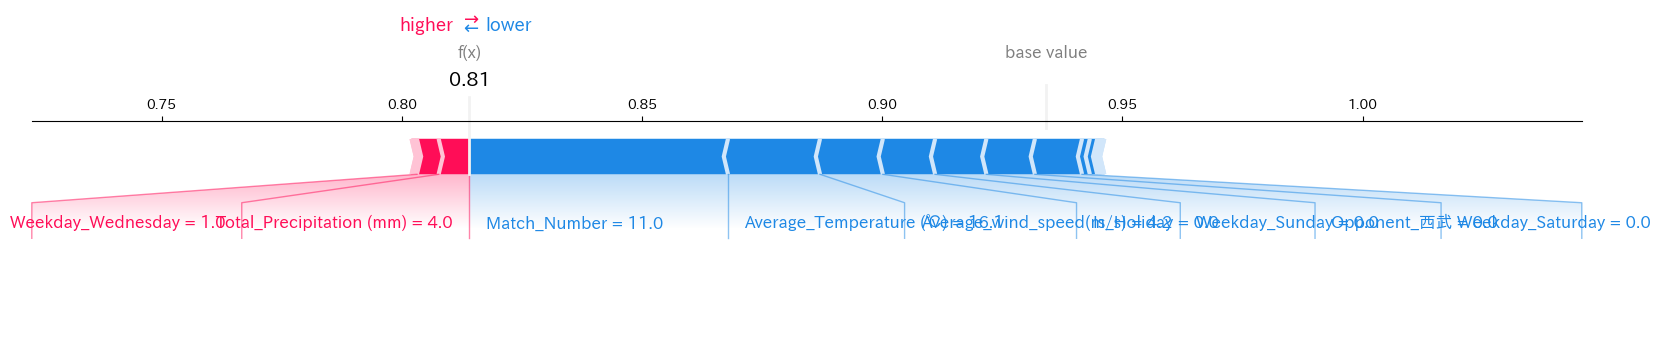

<Figure size 640x480 with 0 Axes>

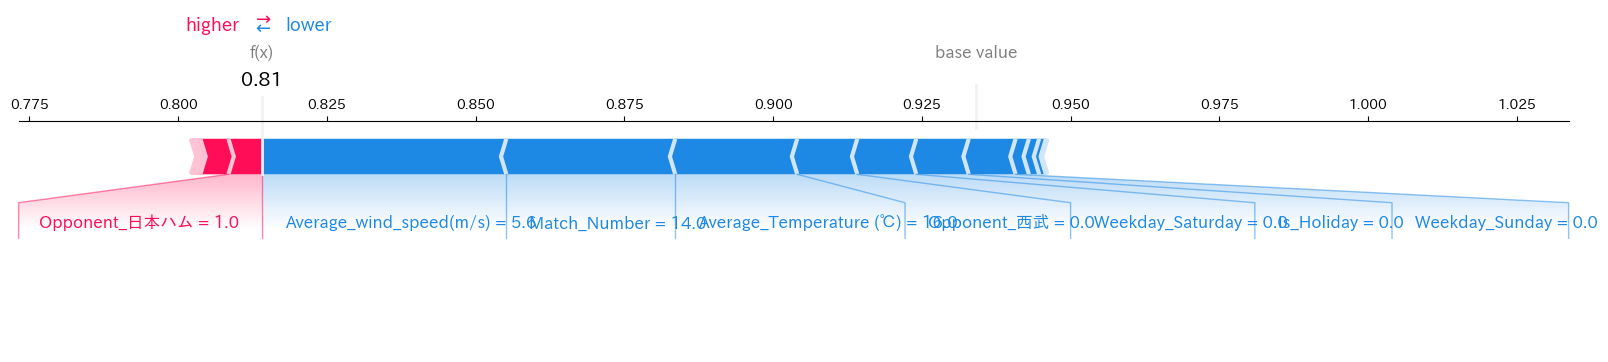

<Figure size 640x480 with 0 Axes>

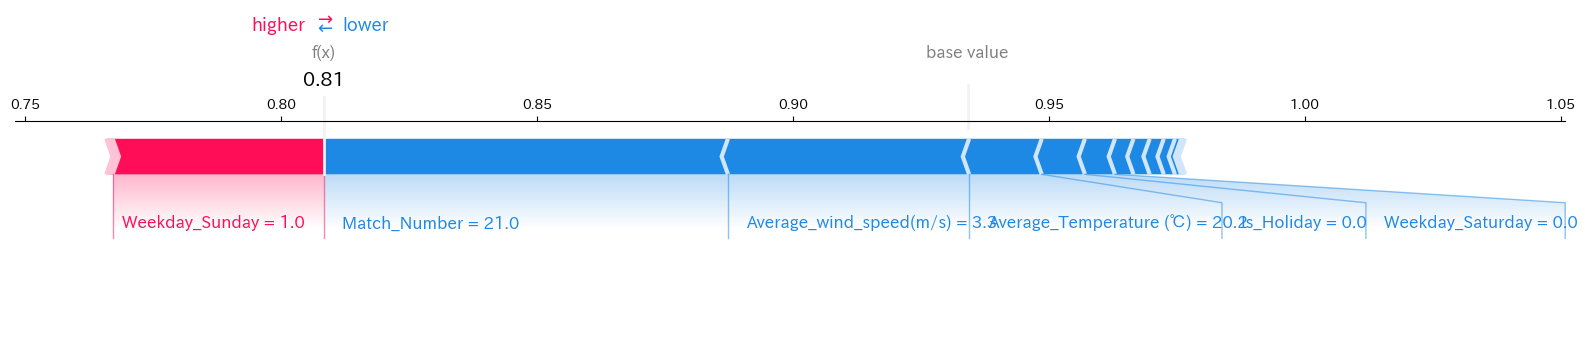

<Figure size 640x480 with 0 Axes>

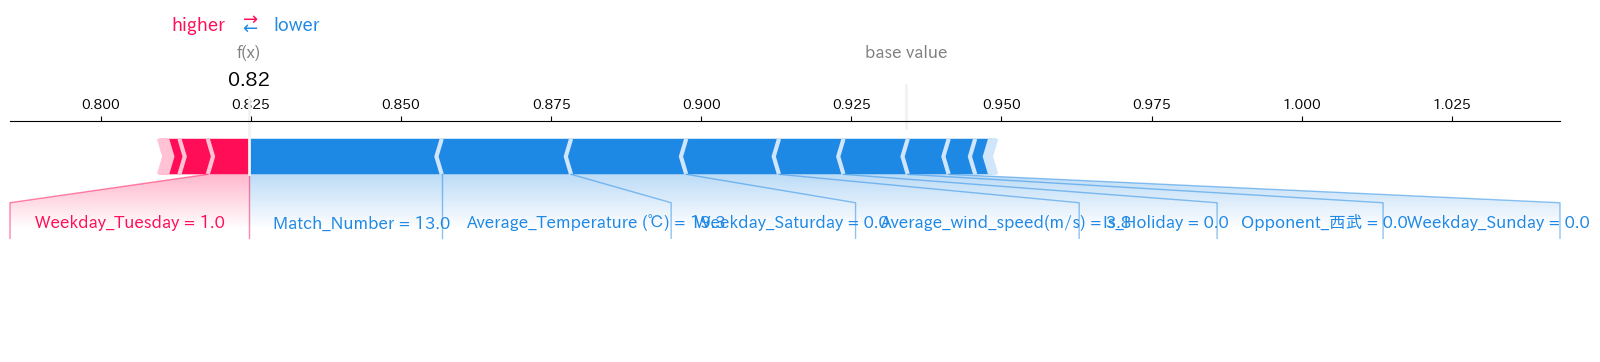

<Figure size 640x480 with 0 Axes>

In [33]:
# SHAP Explainerの作成
explainer = shap.TreeExplainer(model)

# SHAP値の計算
shap_values = explainer.shap_values(X_test)

# 残差の大きいデータのSAHPを表示
# データの結合
combined = pd.concat([X_test, results], axis=1)

# 残差の計算
combined["Residuals"] = combined["Actual"] - combined["Predicted"]

# 残差が大きい順に並べ替え
sorted_combined = combined.sort_values(by="Residuals", ascending=False)

# 上位データの確認
# 指定したインスタンスのインデックス
indices = sorted_combined.head(5).index

# Force Plotを表示
for idx in indices:
    shap.force_plot(explainer.expected_value, shap_values[idx], X_test.iloc[idx], matplotlib=True)
    plt.savefig(f"../results/plots/Froce_Plot{idx}.png")